In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
transform = transforms.ToTensor() #Definindo a conversão da imagem para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) #Carrega as imagens de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle=True) # Cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) #Carrega as imagens de validação do dataset [As imagens de teste]
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

44.3%

100.0%


Extracting ./MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST_data/MNIST\raw


100.0%


Extracting ./MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST\raw



100.0%


Extracting ./MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST\raw



100.0%

Extracting ./MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST\raw



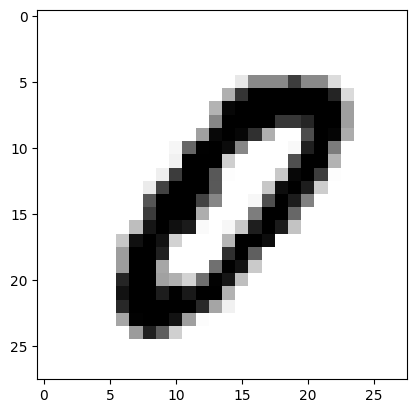

In [61]:
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [8]:
print(imagens[0].shape) #Para verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape) #Para verificar as dimensões do tensor de cada etiqueta
print(etiquetas[0])

torch.Size([1, 28, 28])
torch.Size([])
tensor(4)


In [13]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo,self).__init__()
        self.linear1 = nn.Linear(28*28, 128) #Camada de entrada com 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128,64) #Camada interna 1, 128 neurônios que se ligam a 64
        self.linear3 = nn.Linear(64,10) #Camada interna 2, 64 neurônios que se ligam a 10
        #Para a camada de saída não é necessário definir nada pois só precisamos pegar o output da camada interna 2

    def forward(self,X):
        X = F.relu(self.linear1(X)) #Função de ativação da camada de entrada para a camada interna 1
        X = F.relu(self.linear2(X)) #Função de ativação da camada interna 1 para a camada interna 2
        X = self.linear3(X) #Função de ativação da camada interna 2 para a camada de saída, nesse caso f(x) = x
        return F.log_softmax(X,dim=1) #Dados utilizados para a calcular a perda 

In [48]:
def treino(modelo, trainloader, device):
    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5)
    inicio = time()

    criterio = nn.NLLLoss()
    EPOCHS = 25
    modelo.train()

    for epoch in range(EPOCHS):
        perda_acumulada = 0

        for imagens, etiquetas in trainloader:
            imagens = imagens.view(imagens.shape[0], -1)
            otimizador.zero_grad()

            output = modelo(imagens.to(device))
            perda_instantanea = criterio(output, etiquetas.to(device))

            perda_instantanea.backward()
            otimizador.step()

            perda_acumulada += perda_instantanea.item()

        print("Epoch {} - Perda resultante: {}".format(epoch + 1, perda_acumulada / len(trainloader)))

    print("\n Tempo de treino (em minutos) = ", (time() - inicio) / 60)


In [21]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0
    for imagens, etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1, 784) #Desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem um custo alto de processamento
            with torch.no_grad():
                logps = modelo(img.to(device)) #output do modelo em escala logaritimica
    
        ps = torch.exp(logps) #Converte o output para escala normal (Lembrando que é um tensor)
        probab = list(ps.cpu().numpy()[0])
        etiqueta_pred = probab.index(max(probab)) #Converte o tensor em um número, no caso o número que o modelo previu
        etiqueta_certa = etiquetas.numpy()[i]
        if(etiqueta_certa == etiqueta_pred): #Compara as etiquetas prevista e a correta
            conta_corretas += 1
        conta_todas +=1
    
    print("Total de imagens testadas =", conta_todas)
    print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))

In [22]:
modelo = Modelo()
device = torch.device("cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [49]:
treino(modelo,trainloader,device)

Epoch 1 - Perda resultante: 0.04243341888755814
Epoch 2 - Perda resultante: 0.04048879063034903
Epoch 3 - Perda resultante: 0.03862016515057685
Epoch 4 - Perda resultante: 0.03702334354796421
Epoch 5 - Perda resultante: 0.035282289089539697
Epoch 6 - Perda resultante: 0.033744351522846106
Epoch 7 - Perda resultante: 0.03249322252694581
Epoch 8 - Perda resultante: 0.030777616435408727
Epoch 9 - Perda resultante: 0.029663084126732894
Epoch 10 - Perda resultante: 0.028302000290570235
Epoch 11 - Perda resultante: 0.026976060767251966
Epoch 12 - Perda resultante: 0.02585939287807721
Epoch 13 - Perda resultante: 0.02480351950884906
Epoch 14 - Perda resultante: 0.023827645513636152
Epoch 15 - Perda resultante: 0.022654609933276094
Epoch 16 - Perda resultante: 0.021609598718983714
Epoch 17 - Perda resultante: 0.020682190005892893
Epoch 18 - Perda resultante: 0.019835484714415083
Epoch 19 - Perda resultante: 0.019038931403839304
Epoch 20 - Perda resultante: 0.018149599508280115
Epoch 21 - Perda

In [50]:
validacao(modelo, valloader, device)

Total de imagens testadas = 157

Precisão do modelo = 96.81528662420382%


In [62]:
from PIL import Image
import os

# Caminho para a pasta contendo as imagens
pasta_imagens = 'C:/Users/orlan/OneDrive/Documentos/UFF/DIO/ML/imagens/'

# Lista para armazenar os resultados das previsões
resultados = []

# Percorrer todas as imagens na pasta
for filename in os.listdir(pasta_imagens):
    # Verificar se é um arquivo de imagem
    if filename.endswith(".png"):
        # Caminho completo para a imagem
        caminho_imagem = os.path.join(pasta_imagens, filename)

        # Carregar a imagem usando a biblioteca PIL
        imagem = Image.open(caminho_imagem)

        # Redimensionar a imagem para 28x28 pixels
        imagem = imagem.resize((28, 28))

        # Converter a imagem para escala de cinza
        imagem = imagem.convert('L')

        # Converter a imagem para um array NumPy e normalizar os valores para o intervalo [0, 1]
        imagem_array = np.array(imagem) / 255.0

        # Redimensionar o array para corresponder à entrada do modelo (que espera um batch de tamanho 1)
        imagem_array = imagem_array.reshape(1, -1)

        # Converter o array para o formato Tensor do PyTorch
        imagem_tensor = torch.tensor(imagem_array, dtype=torch.float32)

        with torch.no_grad():
            output = modelo(imagem_tensor)

        # Obter as probabilidades para cada classe
        probabilidades = torch.exp(output)

        # Obter o índice da classe com a maior probabilidade
        classe_predita = torch.argmax(probabilidades)

        # Armazenar o resultado da previsão (índice da classe predita) na lista de resultados
        resultados.append(classe_predita.item())

        # Obter as probabilidades para cada classe
        probabilidades = torch.exp(output)

        # Imprimir as probabilidades para cada classe
        print(f"Probabilidades para a imagem {filename}:")
        for classe, probabilidade in enumerate(probabilidades.squeeze().tolist()):
            print(f"Classe {classe}: {probabilidade:.4f}")


# Imprimir os resultados
for i, filename in enumerate(os.listdir(pasta_imagens)):
    if filename.endswith(".png"):
        print(f"Imagem {filename}: Classe predita = {resultados[i]}")

Probabilidades para a imagem 0.png:
Classe 0: 0.5694
Classe 1: 0.0000
Classe 2: 0.0003
Classe 3: 0.0000
Classe 4: 0.0000
Classe 5: 0.0000
Classe 6: 0.0000
Classe 7: 0.0003
Classe 8: 0.0000
Classe 9: 0.4299
Probabilidades para a imagem 1.png:
Classe 0: 0.0000
Classe 1: 0.0006
Classe 2: 0.0009
Classe 3: 0.0091
Classe 4: 0.0000
Classe 5: 0.0000
Classe 6: 0.0000
Classe 7: 0.6721
Classe 8: 0.0000
Classe 9: 0.3173
Probabilidades para a imagem 3.png:
Classe 0: 0.0000
Classe 1: 0.0000
Classe 2: 0.0000
Classe 3: 1.0000
Classe 4: 0.0000
Classe 5: 0.0000
Classe 6: 0.0000
Classe 7: 0.0000
Classe 8: 0.0000
Classe 9: 0.0000
Probabilidades para a imagem 4.png:
Classe 0: 0.0000
Classe 1: 0.0000
Classe 2: 0.0000
Classe 3: 0.0001
Classe 4: 0.1704
Classe 5: 0.0000
Classe 6: 0.0000
Classe 7: 0.0010
Classe 8: 0.0001
Classe 9: 0.8284
Probabilidades para a imagem 7.png:
Classe 0: 0.0000
Classe 1: 0.0000
Classe 2: 0.0000
Classe 3: 0.0000
Classe 4: 0.0000
Classe 5: 0.0000
Classe 6: 0.0000
Classe 7: 1.0000
Clas